In [2]:
%pylab inline

import pyart
import wradlib as wrl
import pandas as pd
import tempfile
import os
import pandas as pd

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

from copy import deepcopy
import boto3
from botocore.handlers import disable_signing

import datetime as dt
import pytz

import scipy.signal as ss

Populating the interactive namespace from numpy and matplotlib

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/wradlib/io/radolan.py:835: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'RR': {'add_offset': np.float(0),
/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/wradlib/io/radolan.py:842: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'RA': {'add_offset': np.float(0),


In [3]:
#d = np.load('qvp_10deg_20150206.hdf5.npy', allow_pickle=True)
datadir = './QVPsector_10deg/'
fname = 'qvp_sector_10deg_20111005.hdf5.npy'
#fname = 'qvp_sector_10deg_20110604.hdf5.npy'
d = np.load(os.path.join(datadir,fname), allow_pickle=True)

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
qvp_sea_refl = d.item()['qvp_sea_reflectivity']
qvp_sea_time = d.item()['qvp_sea_time']
qvp_sea_height = d.item()['qvp_sea_height']
qvp_sea_range = d.item()['qvp_sea_range']

qvp_land_refl = d.item()['qvp_land_reflectivity']
qvp_land_time = d.item()['qvp_land_time']
qvp_land_height = d.item()['qvp_land_height']
qvp_land_range = d.item()['qvp_land_range']

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


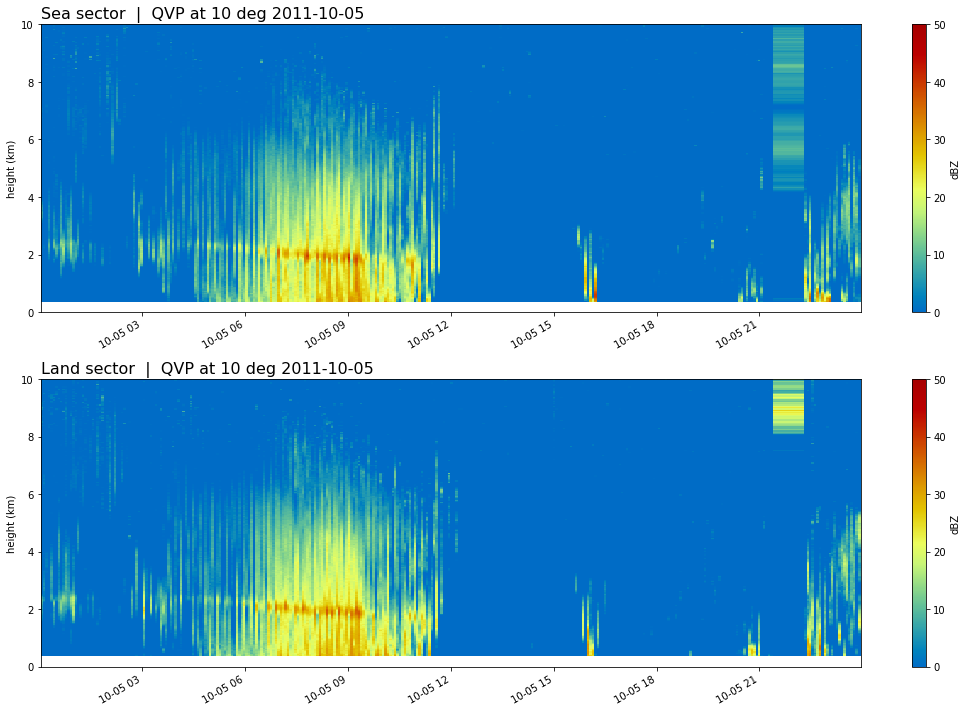

In [5]:
# Plot
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(211)
qmesh = plt.pcolormesh(qvp_sea_time, qvp_sea_height[-1]/1000., qvp_sea_refl.T, 
                       vmin=0, vmax=50, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
ax1 = plt.gca()
cb = fig.colorbar(qmesh,ax=ax1)
cb.set_label('dBZ')
ax1.axis('tight')
ax1.set_ylabel('height (km)')
# Set up as dates
ax1.xaxis_date()
ax1.set_ylim((0,10))


ax2 = fig.add_subplot(212)
qmesh = plt.pcolormesh(qvp_land_time, qvp_land_height[-1]/1000., qvp_land_refl.T, 
                       vmin=0, vmax=50, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
ax2 = plt.gca()
cb = fig.colorbar(qmesh,ax=ax2)
cb.set_label('dBZ')
ax2.axis('tight')
ax2.set_ylabel('height (km)')
# Set up as dates
ax2.xaxis_date()
ax2.set_ylim((0,10))

titlestr = dt.datetime.strptime(fname, 'qvp_sector_10deg_%Y%m%d.hdf5.npy')
timestr = dt.datetime.strftime(titlestr, '%Y%m%d')

ax1.set_title('Sea sector  |  QVP at 10 deg ' +str(titlestr.date()), loc='left', fontsize=16)
ax2.set_title('Land sector  |  QVP at 10 deg ' +str(titlestr.date()), loc='left', fontsize=16)

fig.autofmt_xdate()

savefname = 'QVP_sealand_sector_' + timestr + '.png'
plt.tight_layout()
#plt.savefig(savefname)
#ax.set_title("QVP at 10 deg " +str(titlestr.date()))

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.0, 10.0)

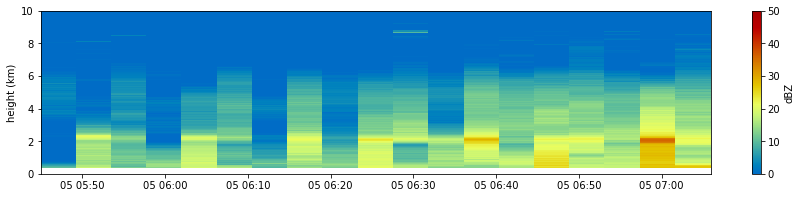

In [6]:
# Plot
fig = plt.figure(figsize=(15,3))

ax1 = fig.add_subplot(111)
# qmesh = plt.pcolormesh(qvp_sea_time[50:60], qvp_sea_height[-1]/1000., qvp_sea_refl[50:60].T, 
#                        vmin=0, vmax=50, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
# qmesh = plt.pcolormesh(qvp_sea_time[150:165], qvp_sea_height[-1]/1000., qvp_sea_refl[150:165].T, 
#                        vmin=0, vmax=50, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
qmesh = plt.pcolormesh(qvp_sea_time[80:100], qvp_sea_height[-1]/1000., qvp_sea_refl[80:100].T, 
                       vmin=0, vmax=50, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
ax1 = plt.gca()
cb = fig.colorbar(qmesh,ax=ax1)
cb.set_label('dBZ')
ax1.axis('tight')
ax1.set_ylabel('height (km)')
# Set up as dates
ax1.xaxis_date()
ax1.set_ylim((0,10))



# Find peaks

In [7]:
len(qvp_land_refl)

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


325

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


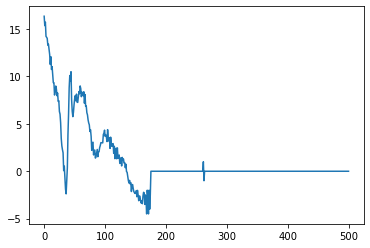

In [8]:
x = qvp_land_refl[84][:500]

peaks, _ = ss.find_peaks(x,height=15,width=[2,10],rel_height=0.2)#,prominence=3)
results_half = ss.peak_widths(x, peaks, rel_height=0.2)
prominences = ss.peak_prominences(x, peaks)[0]
contour_heights = x[peaks] - prominences
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.vlines(x=peaks, ymin=contour_heights, ymax=x[peaks])
plt.hlines(*results_half[1:], color="C2")
plt.show()
print(*results_half[0])

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


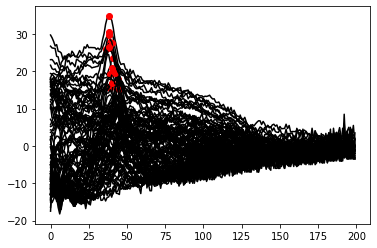

In [9]:
peaks = []
peaks_y = []

for i in range(len(qvp_land_refl[:100])):
    test_signal = qvp_land_refl[i][:200]
    pk = ss.find_peaks(test_signal,width=[3,10],rel_height=0.2, height=15)
    peaks.append(pk[0])
    
    test_signaly = test_signal[pk[0]]
    peaks_y.append(test_signaly)
    
    plt.plot(test_signal,'k-')
    plt.plot(pk[0],test_signaly,'ro')

In [10]:
peaks = []
peaks_y = []
ML_heights = []
refl = qvp_land_refl

# for i in range(len(qvp_land_refl)):
#     test_signal = qvp_land_refl[i][:500]
#     pk = ss.find_peaks(test_signal,width=[5,10],rel_height=0.1, height=15)
#     peaks.append(pk[0])
    
#     test_signaly = test_signal[pk[0]]
#     peaks_y.append(test_signaly)
    
#     MLheight = qvp_land_height[i][pk[0]]
#     try:
#         ML_heights.append(MLheight[-1])
#     except IndexError:
#         ML_heights.append(np.nan)

for i in range(len(refl)):
    test_signal = refl[i][:500]
    pk,meta = ss.find_peaks(test_signal,width=[3,15],rel_height=0.2, height=15) # height is minimum reflectivity considered as ML
    peaks.append(pk)

    test_signaly = test_signal[pk]
    peaks_y.append(test_signaly)

    try:
        max_idx = np.where(meta['peak_heights'] == max(meta['peak_heights']))[0][0]
        MLheight = qvp_land_height[i][pk[max_idx]]
        ML_heights.append(MLheight)
    except ValueError:
        ML_heights.append(np.nan)

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


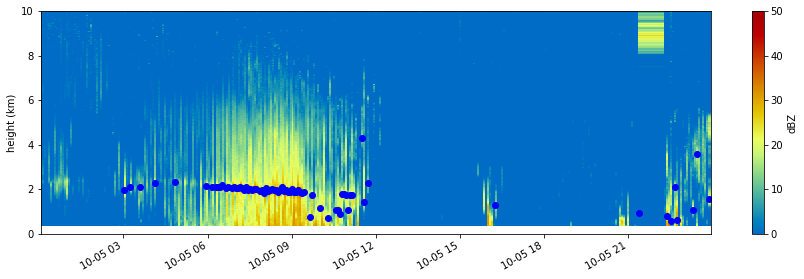

In [11]:
# Plot
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(211)
qmesh = plt.pcolormesh(qvp_land_time, qvp_land_height[-1]/1000., qvp_land_refl.T, 
                       vmin=0, vmax=50, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
ax1 = plt.gca()
cb = fig.colorbar(qmesh,ax=ax1)
cb.set_label('dBZ')
ax1.axis('tight')
ax1.set_ylabel('height (km)')
# Set up as dates
ax1.xaxis_date()
ax1.set_ylim((0,10))

ax1.plot(qvp_land_time,np.array(ML_heights)/1000.,'bo')


fig.autofmt_xdate()

# savefname = 'QVP_sealand_sector_' + timestr + '.png'
# plt.tight_layout()
# plt.savefig(savefname)
#ax.set_title("QVP at 10 deg " +str(titlestr.date()))